# Dream5 n_estimators plots


In [5]:
import os
import sys
sys.path.append('../../')

from arboreto.algo import *
from arboreto.core import *
from arboreto.utils import *

from sklearn import preprocessing

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data paths

In [6]:
wd = os.getcwd().split('arboreto')[0] + 'arboreto/resources/dream5/'

net1_ex_path = wd + 'net1/net1_expression_data.tsv'
net1_tf_path = wd + 'net1/net1_transcription_factors.tsv'

net3_ex_path = wd + 'net3/net3_expression_data.tsv'
net3_tf_path = wd + 'net3/net3_transcription_factors.tsv'

net4_ex_path = wd + 'net4/net4_expression_data.tsv'
net4_tf_path = wd + 'net4/net4_transcription_factors.tsv'

In [7]:
grnboost2?

Signature: grnboost2(expression_data, gene_names=None, tf_names='all', client_or_address='local', early_stop_window_length=25, limit=None, seed=None, verbose=False)
Docstring:
Launch arboreto with [GRNBoost2] profile.

:param expression_data: one of:
       * a pandas DataFrame (rows=observations, columns=genes)
       * a dense 2D numpy.ndarray
       * a sparse scipy.sparse.csc_matrix
:param gene_names: optional list of gene names (strings). Required when a (dense or sparse) matrix is passed as
                   'expression_data' instead of a DataFrame.
:param tf_names: optional list of transcription factors. If None or 'all', the list of gene_names will be used.
:param client_or_address: one of:
       * None or 'local': a new Client(LocalCluster()) will be used to perform the computation.
       * string address: a new Client(address) will be used to perform the computation.
       * a Client instance: the specified Client instance will be used to perform the computation.
:param e

## Dask client

In [8]:
from dask.distributed import Client, LocalCluster

In [9]:
client = Client(LocalCluster())

In [10]:
client

Client Scheduler: tcp://127.0.0.1:40127 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 88 Cores: 88 Memory: 135.07 GB


Use port forwarding to view the dashboard `$ ssh -L 8000:localhost:8787 nostromo`

In [6]:
#client.close()

## Infer networks (with meta)

In [15]:
def infer_network_and_meta(ex_path, tf_path, client):
    ex_matrix = pd.read_csv(ex_path, sep='\t')
    gene_names = ex_matrix.columns
    tf_names = load_tf_names(tf_path)
    
    network_graph, meta_graph = create_graph(ex_matrix.as_matrix(),
                                             gene_names,
                                             tf_names,
                                             "GBM",
                                             SGBM_KWARGS,
                                             client=client, # broadcast!
                                             early_stop_window_length=25,
                                             include_meta=True)
    # Good!
    a, b = client.persist([network_graph, meta_graph])
    network_df = a.compute(sync=True)
    meta_df = b.compute(sync=True)
    
    return network_df, meta_df

In [16]:
%%time
net1, meta1 = infer_network_and_meta(net1_ex_path, net1_tf_path, client)

CPU times: user 37.5 s, sys: 10.9 s, total: 48.4 s
Wall time: 54.7 s


In [17]:
%%time
net3, meta3 = infer_network_and_meta(net3_ex_path, net3_tf_path, client)

CPU times: user 2min 29s, sys: 55.7 s, total: 3min 25s
Wall time: 4min


In [18]:
%%time
net4, meta4 = infer_network_and_meta(net4_ex_path, net4_tf_path, client)

CPU times: user 2min 35s, sys: 49.8 s, total: 3min 25s
Wall time: 4min


In [27]:
from seaborn import kdeplot

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


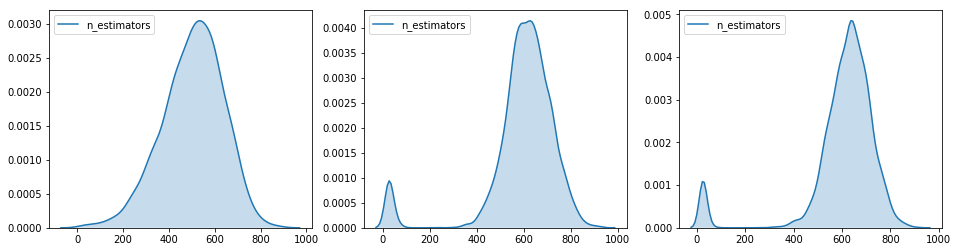

In [63]:
f, ax = plt.subplots(ncols=3, figsize=(16,4))

ax1 = sns.kdeplot(meta1.n_estimators, shade=True, ax=ax[0])
ax2 = sns.kdeplot(meta3.n_estimators, shade=True, ax=ax[1])
ax3 = sns.kdeplot(meta4.n_estimators, shade=True, ax=ax[2])

plt.savefig('dream5_n_estimators.svg')
plt.show()